In [33]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import sklearn
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

import tensorflow as tf
from tensorflow import keras
from keras import models, layers, optimizers, losses, preprocessing, regularizers
import tensorflow_hub as hub
import tensorflow_text

import xgboost as xgb
import catboost as cb

from transformers import BertTokenizer, TFBertModel

In [2]:
os.environ["WANDB_API_KEY"] = "0" ## to silence warning

# Check if GPU is available

In [3]:
tf.config.list_physical_devices(device_type='GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Load Data

In [4]:
df_train = pd.read_csv('../../Data/contradictory-my-dear-watson/train.csv')
df_test  = pd.read_csv('../../Data/contradictory-my-dear-watson/test.csv')

df_all = pd.concat([df_train, df_test])

print(f'df_train.shape = {df_train.shape}')
print(f'df_test.shape  = {df_test.shape}')
print(f'df_all.shape   = {df_all.shape}')

df_train.shape = (12120, 6)
df_test.shape  = (5195, 5)
df_all.shape   = (17315, 6)


In [5]:
df_train.head(2)

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2


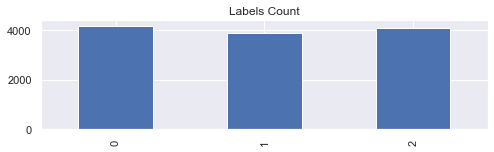

In [6]:
_ = df_train['label'].value_counts().sort_index().plot.bar(figsize=(8,2), title='Labels Count')

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12120 entries, 0 to 12119
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          12120 non-null  object
 1   premise     12120 non-null  object
 2   hypothesis  12120 non-null  object
 3   lang_abv    12120 non-null  object
 4   language    12120 non-null  object
 5   label       12120 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 568.2+ KB


## Preparing Data for Input

To start out, we can use a pretrained model. Here, we'll use a multilingual BERT model from huggingface. For more information about BERT, see: https://github.com/google-research/bert/blob/master/multilingual.md

First, we download the tokenizer.

In [8]:
model_name = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)

In [9]:
len(tokenizer.vocab)

119547

### Tokenizers turn sequences of words into arrays of numbers. Let's look at an example:

In [10]:
def encode_sentence(s):
    tokens = list(tokenizer.tokenize(s))
    tokens.append('[SEP]')
    return tokenizer.convert_tokens_to_ids(tokens)

In [11]:
encode_sentence("you know they can't really defend themselves")

[13028, 21852, 10689, 10944, 112, 188, 30181, 60041, 20182, 102]

## BERT
[BERT](https://huggingface.co/transformers/model_doc/bert.html#tfbertmodel) **uses three kind of input data** - input word IDs, input masks, and input type IDs.

These allow the model to know that **the premise and hypothesis are distinct sentences**, and also to ignore any padding from the tokenizer.

We add a [CLS] token to denote **the beginning of the inputs**, and a [SEP] token to denote the separation between **the premise and the hypothesis**. 

We also **need to pad** all of the inputs to be the same size.

Now, we're going to **encode all of our premise/hypothesis pairs** for input into BERT.

In [12]:
def bert_encode(hypotheses, premises, tokenizer):
    
    num_examples = len(hypotheses)
    print("num_examples = ", num_examples)
    
    sentence1 = tf.ragged.constant([
            encode_sentence(s) for s in np.array(hypotheses)
    ])
    print("sentence1.shape = ", sentence1.shape)
    
    sentence2 = tf.ragged.constant([
        encode_sentence(s) for s in np.array(premises)
    ])
    print("sentence2.shape = ", sentence2.shape)

    cls_ = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
    input_word_ids = tf.concat([cls_, sentence1, sentence2], axis=-1)
    print("input_word_ids.shape = ", input_word_ids.shape)

    input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(input_word_ids.shape[0], 300))
    print("input_mask.shape = ", input_mask.shape)
    
    type_cls = tf.zeros_like(cls_)
    type_s1 = tf.zeros_like(sentence1)
    type_s2 = tf.ones_like(sentence2)
    
    input_type_ids = tf.concat([type_cls, type_s1, type_s2], axis=-1).to_tensor(shape=(input_word_ids.shape[0], 300))
    
    inputs = {
        'input_word_ids': input_word_ids.to_tensor(shape=(input_word_ids.shape[0], 300)),
        'input_mask': input_mask,
        'input_type_ids': input_type_ids}
    
    print()
    
    return inputs

In [13]:
train_input = bert_encode(df_train.premise.values, df_train.hypothesis.values, tokenizer)
test_input  = bert_encode(df_test.premise.values, df_test.hypothesis.values, tokenizer)

num_examples =  12120
sentence1.shape =  (12120, None)
sentence2.shape =  (12120, None)
input_word_ids.shape =  (12120, None)
input_mask.shape =  (12120, 300)

num_examples =  5195
sentence1.shape =  (5195, None)
sentence2.shape =  (5195, None)
input_word_ids.shape =  (5195, None)
input_mask.shape =  (5195, 300)



## Creating & Training Model

Now, we can incorporate the BERT transformer into a Keras Functional Model. For more information about the Keras Functional API, see: https://www.tensorflow.org/guide/keras/functional.

This model was inspired by the model in this notebook: https://www.kaggle.com/tanulsingh077/deep-learning-for-nlp-zero-to-transformers-bert#BERT-and-Its-Implementation-on-this-Competition, which is a wonderful introduction to NLP!

In [23]:
max_len = train_input["input_word_ids"].shape[1]

def build_model():    
    bert_encoder = TFBertModel.from_pretrained(model_name)
    
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_type_ids")
    
    embedding = bert_encoder([input_word_ids, input_mask, input_type_ids])[0]
    
    output = tf.keras.layers.Dense(3, activation='softmax')(embedding[:,0,:])
    
    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
   
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
        loss='sparse_categorical_crossentropy', 
        metrics=['accuracy'],
    )
    
    return model

In [24]:
model = build_model()
model.summary()

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 300)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 300)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model_4 (TFBertModel)  TFBaseModelOutputWi  177853440   ['input_word_ids[0][0]',         
                                thPooling(last_hidd               'input_mask[0][0]',       

In [26]:
model_history = model.fit(train_input, 
                          df_train["label"].values, 
                          epochs = 20, 
                          verbose = 1,
                          batch_size = 16, 
                          validation_split = 0.2)

Epoch 1/20
606/606 [==============================] - 163s 268ms/step - loss: 0.9324 - accuracy: 0.5541 - val_loss: 0.8492 - val_accuracy: 0.6221
Epoch 2/20
606/606 [==============================] - 162s 267ms/step - loss: 0.6778 - accuracy: 0.7090 - val_loss: 0.8437 - val_accuracy: 0.6444
Epoch 3/20
606/606 [==============================] - 162s 267ms/step - loss: 0.4502 - accuracy: 0.8224 - val_loss: 0.9162 - val_accuracy: 0.6572
Epoch 4/20
606/606 [==============================] - 162s 267ms/step - loss: 0.2843 - accuracy: 0.8970 - val_loss: 1.0962 - val_accuracy: 0.6568
Epoch 5/20
606/606 [==============================] - 169s 279ms/step - loss: 0.1677 - accuracy: 0.9414 - val_loss: 1.3773 - val_accuracy: 0.6411
Epoch 6/20
606/606 [==============================] - 162s 267ms/step - loss: 0.1159 - accuracy: 0.9603 - val_loss: 1.6603 - val_accuracy: 0.6390
Epoch 7/20
606/606 [==============================] - 162s 267ms/step - loss: 0.0751 - accuracy: 0.9754 - val_loss: 2.1034 -

In [34]:
def plot_NN_history(model_history, suptitle):
    # plot data
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
    fig.suptitle(suptitle, fontsize=18)
    
    axes[0].plot(model_history.history['accuracy'], label='train accuracy', color='g', axes=axes[0])
    axes[0].plot(model_history.history['val_accuracy'], label='val accuracy', color='r', axes=axes[0])
    axes[0].set_title("Model Accuracy", fontsize=16) 
    axes[0].legend(loc='upper left')

    axes[1].plot(model_history.history['loss'], label='train loss', color='g', axes=axes[1])
    axes[1].plot(model_history.history['val_loss'], label='val loss', color='r', axes=axes[1])
    axes[1].set_title("Model Loss", fontsize=16) 
    axes[1].legend(loc='upper left')

    plt.show()

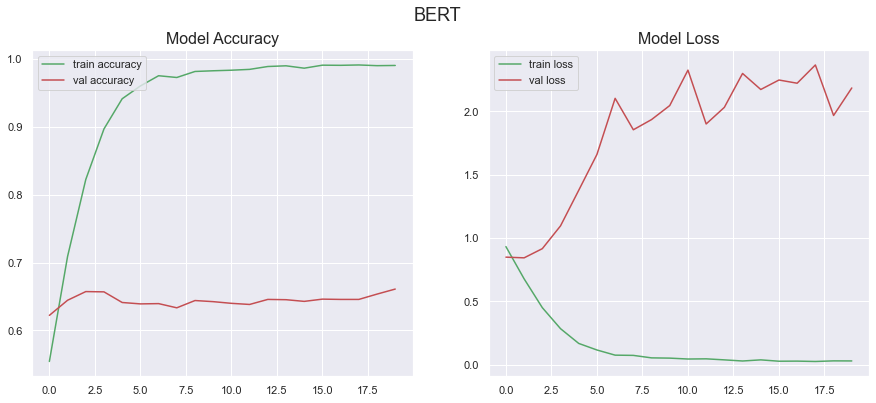

In [35]:
plot_NN_history(model_history, "BERT")

## Generating & Submitting Predictions

In [36]:
predictions = [np.argmax(i) for i in model.predict(test_input)]

163/163 [==============================] - 24s 146ms/step


The submission file will consist of the ID column and a prediction column. We can just copy the ID column from the test file, make it a dataframe, and then add our prediction column.

In [37]:
submission = df_test.id.copy().to_frame()
submission['prediction'] = predictions

In [38]:
submission.to_csv("submission.csv", index = False)